In [1]:
#| hide
# check if in colab and install package as needed
![ -e /content ] && ! pip show fastai-torchgeo && pip install git+https://github.com/butchland/fastai-torchgeo.git
![ -e /content ] && ! pip show nbdev && pip install nbdev

# EuroSAT Land Use/Land Cover (LULC) Classification Tutorial
> finetune a torchgeo pretrained resnet model on the torchgeo EuroSAT dataset for LULC

[![](https://raw.githubusercontent.com/butchland/fastai-torchgeo/master/assets/colab.svg)](https://colab.research.google.com/github/butchland/fastai-torchgeo/blob/master/nbs/tutorial/03-eurosat-classification.ipynb)

This is tutorial on finetuning a [pretrained torchgeo resnet model](https://torchgeo.readthedocs.io/en/stable/api/models.html#resnet) on the [torchgeo EuroSAT dataset](https://torchgeo.readthedocs.io/en/stable/api/datasets.html#eurosat)
using the [fastai](https://docs.fast.ai) framework.

> Note: this tutorial assumes _some_ familiarity with the fastai deep learning package and will focus on torchgeo integration.

## Installation 

Install the package

```bash
pip install git+https://github.com/butchland/fastai-torchgeo.git
```

## Import the packages and download the EuroSAT dataset 

In [2]:
from torchgeo.datasets import EuroSAT
from torchgeo.datamodules import EuroSATDataModule 
from torchgeo.models import ResNet50_Weights, resnet50

import fastai.vision.all as fv

from fastai_torchgeo.data import GeoImageBlock
from fastai_torchgeo.resnet import make_resnet_model, resnet_split

## Create a fastai datablock and fastai dataloaders  

In [3]:
batch_size=64
num_workers = fv.defaults.cpus
dset_name = 'EuroSAT'

In [4]:
dblock = fv.DataBlock(blocks=(GeoImageBlock(), fv.CategoryBlock()),
                      get_items=fv.get_image_files,
                      splitter=fv.RandomSplitter(valid_pct=0.2, seed=42),
                      get_y=fv.parent_label,
                      item_tfms=fv.Resize(64),
                      batch_tfms=[fv.Normalize.from_stats(EuroSATDataModule.mean, EuroSATDataModule.std)],
                     )

In [5]:
cfg = fv.fastai_cfg()
data_dir = cfg.path('data')
dset_path = data_dir/dset_name

In [6]:
datamodule = EuroSATDataModule(root=dset_path,batch_size=batch_size, num_workers=num_workers, download=True)

In [7]:
%%time
datamodule.prepare_data()

CPU times: user 72.8 ms, sys: 8.16 ms, total: 80.9 ms
Wall time: 80.2 ms


Setting-up type transforms pipelines
Found 27000 items
2 datasets of sizes 21600,5400
Setting up Pipeline: partial
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: partial
    starting from
      /home/studio-lab-user/.fastai/data/EuroSAT/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/Highway/Highway_427.tif
    applying partial gives
      GeoTensorImage of size 13x64x64
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/studio-lab-user/.fastai/data/EuroSAT/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/Highway/Highway_427.tif
    applying parent_label gives
      Highway
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(3)

Final sample: (GeoTensorImage: torch.Size([13, 64, 64]), TensorCategory(3))


Found 27000 items
2 datasets of sizes 21600,5400
Setting up Pipeline: par

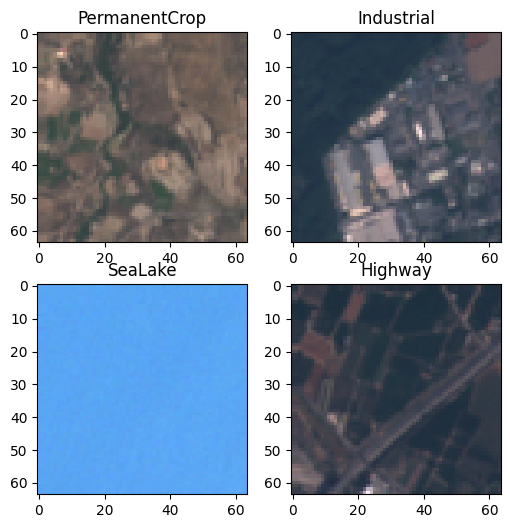

In [8]:
dblock.summary(dset_path, show_batch=True)

In [9]:
dls = dblock.dataloaders(dset_path, bs=batch_size)

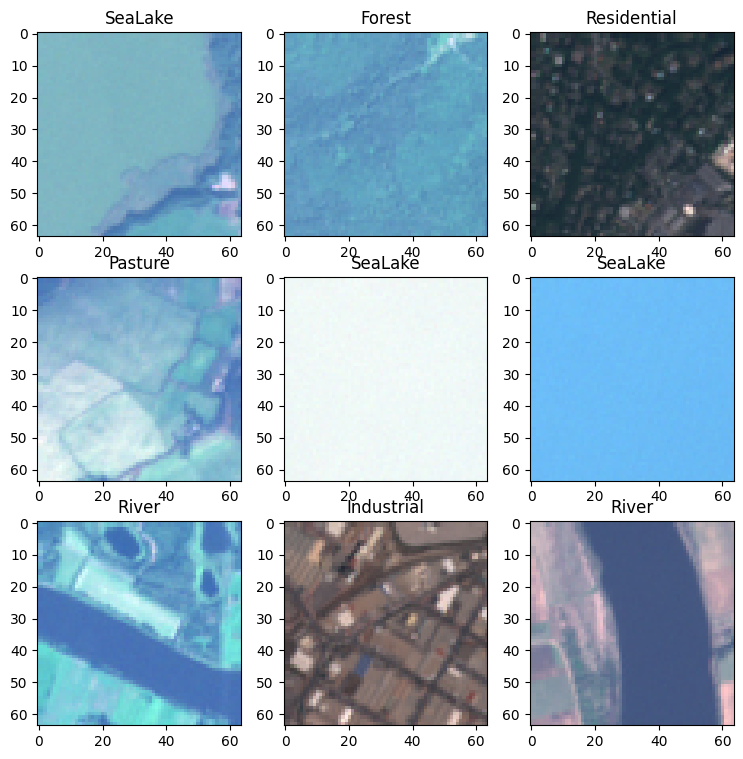

In [14]:
dls.show_batch()

## Download the torchgeo pretrained resnet model and prepare a fastai compatible model

In [15]:
pretrained = resnet50(ResNet50_Weights.SENTINEL2_ALL_MOCO, num_classes=10) # load pretrained weights

In [16]:
model = make_resnet_model(pretrained, n_out=10)

## Create a fastai learner

In [17]:
learn = fv.Learner(
    dls, 
    model,
    loss_func=fv.CrossEntropyLossFlat(),
    metrics=[fv.accuracy],
    splitter=resnet_split,
)
# freeze uses parameter groups created by `resnet_split` 
# to lock parameters of pretrained model except for the model head

learn.freeze()

In [18]:
# note: only head parameter group is trainable (except BatchNorm layers w/ch are always trainable)
learn.summary()

Sequential (Input shape: 64 x 13 x 64 x 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 32 x 32   
Conv2d                                    40768      False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 16 x 16   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Identity                                                       
ReLU                                                           
Identity                   

## Train the model

SuggestedLRs(valley=0.0006918309954926372)

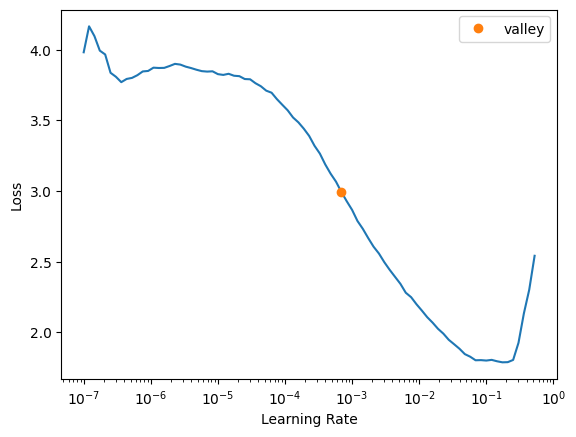

In [19]:
learn.lr_find()

In [20]:
from fastai.callback.tracker import SaveModelCallback
import numpy as np

In [21]:
learn.fine_tune(10, freeze_epochs=3,base_lr=7e-4, cbs=[SaveModelCallback(monitor='accuracy',fname='euronet-resnet50-stage1')])

epoch,train_loss,valid_loss,accuracy,time
0,0.494235,0.293842,0.907778,00:41
1,0.333531,0.231448,0.921481,00:41
2,0.239049,0.184895,0.939444,00:41


Better model found at epoch 0 with accuracy value: 0.9077777862548828.
Better model found at epoch 1 with accuracy value: 0.9214814901351929.
Better model found at epoch 2 with accuracy value: 0.9394444227218628.


epoch,train_loss,valid_loss,accuracy,time
0,0.162829,0.124671,0.959074,00:43
1,0.088713,0.112167,0.963148,00:43
2,0.063464,0.126567,0.962037,00:43
3,0.055648,0.104110,0.968889,00:43
4,0.032861,0.103171,0.970741,00:45
5,0.021249,0.102579,0.972222,00:44
6,0.010938,0.102371,0.973333,00:43
7,0.005382,0.097377,0.974074,00:43
8,0.004003,0.101503,0.973889,00:44
9,0.002489,0.098339,0.976296,00:44


Better model found at epoch 0 with accuracy value: 0.959074079990387.
Better model found at epoch 1 with accuracy value: 0.9631481766700745.
Better model found at epoch 3 with accuracy value: 0.9688888788223267.
Better model found at epoch 4 with accuracy value: 0.9707407355308533.
Better model found at epoch 5 with accuracy value: 0.9722222089767456.
Better model found at epoch 6 with accuracy value: 0.9733333587646484.
Better model found at epoch 7 with accuracy value: 0.9740740656852722.
Better model found at epoch 9 with accuracy value: 0.9762963056564331.


In [22]:
learn.save('euronet-resnet50-stage1-final')

Path('models/euronet-resnet50-stage1-final.pth')

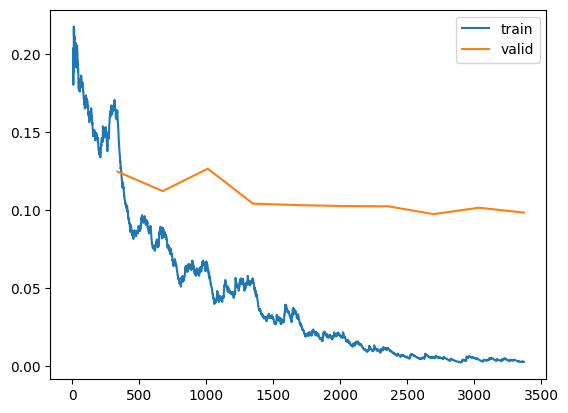

In [23]:
learn.recorder.plot_loss()

In [24]:
learn.summary()

Sequential (Input shape: 64 x 13 x 64 x 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 32 x 32   
Conv2d                                    40768      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 16 x 16   
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Identity                                                       
ReLU                                                           
Identity                   

In [29]:
learn.fit_one_cycle(20, lr_max=slice(3e-3, 6e-6), cbs=[SaveModelCallback(monitor='accuracy',fname='euronet-resnet50-stage2')])

epoch,train_loss,valid_loss,accuracy,time
0,0.035239,0.170115,0.959259,00:44
1,0.154670,0.230367,0.944815,00:44
2,0.207444,0.338804,0.908889,00:44
3,0.170779,0.218512,0.938704,00:44
4,0.176847,0.216765,0.937593,00:44
5,0.159534,0.193209,0.940926,00:44
6,0.120023,0.179367,0.944444,00:44
7,0.095654,0.156686,0.953148,00:44
8,0.069015,0.181001,0.948519,00:44
9,0.053350,0.164088,0.952222,00:44


Better model found at epoch 0 with accuracy value: 0.9592592716217041.
Better model found at epoch 10 with accuracy value: 0.9646296501159668.
Better model found at epoch 11 with accuracy value: 0.9729629755020142.
Better model found at epoch 13 with accuracy value: 0.9731481671333313.
Better model found at epoch 14 with accuracy value: 0.976111114025116.
Better model found at epoch 15 with accuracy value: 0.9768518805503845.
Better model found at epoch 16 with accuracy value: 0.9775925874710083.
Better model found at epoch 17 with accuracy value: 0.9794444441795349.
Better model found at epoch 18 with accuracy value: 0.9801852107048035.


## Post training (error analysis and setting up for inference)

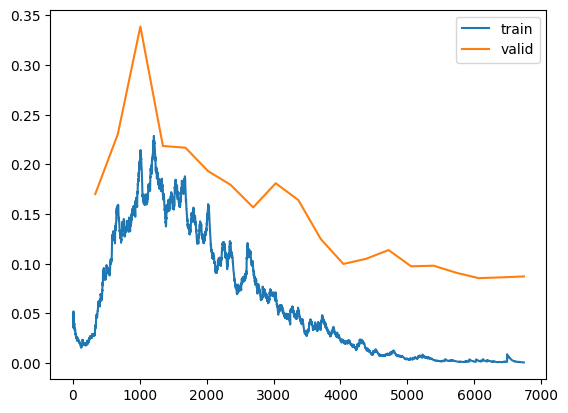

In [30]:
learn.recorder.plot_loss()

In [31]:
learn.save('euronet-resnet50-stage2-final')

Path('models/euronet-resnet50-stage2-final.pth')

In [32]:
learn.validate()

(#2) [0.08627868443727493,0.9801852107048035]

In [33]:
interp = fv.ClassificationInterpretation.from_learner(learn)

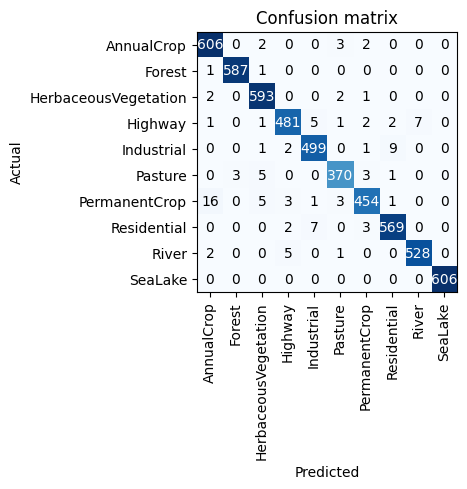

In [34]:
interp.plot_confusion_matrix()

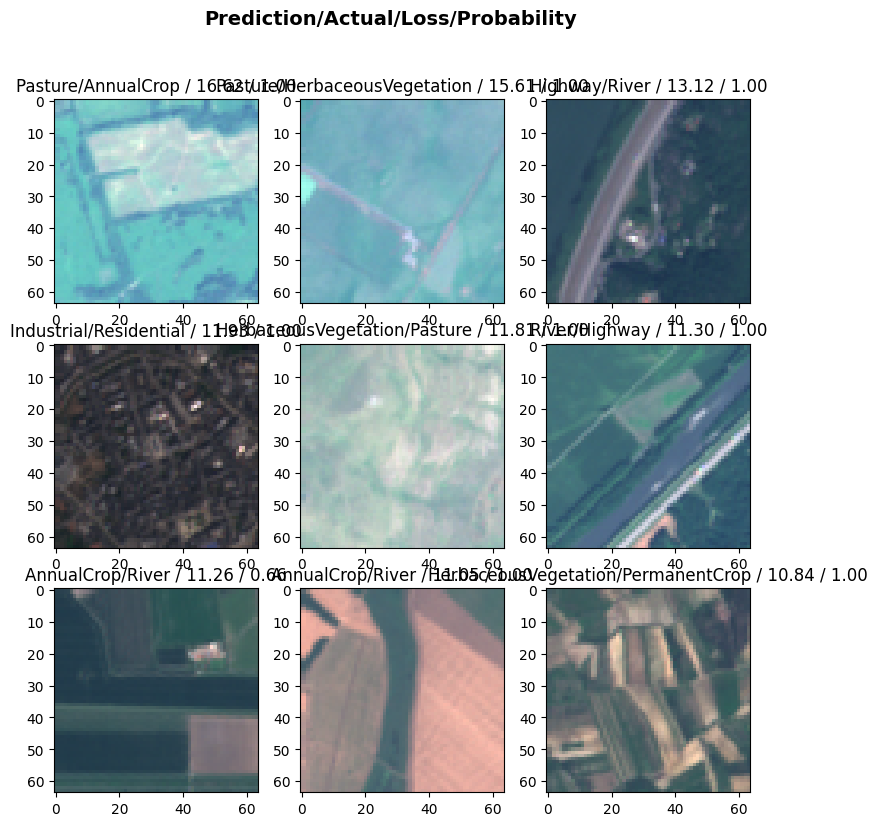

In [35]:
interp.plot_top_losses(9)